<img src="http://curiousily.com/assets/11.tensorflow_for_hackers_part_1_files/tensors_flowing.gif" width="50%" height="40%"/>

# Graphs

Everything you do in TensorFlow is based on computational graphs. Each node of the graph defines an operation. The operation can be any function - addition, multiplication or some funky custom function you wrote.

## Tensors

You can give a scalar value, vector, matrix or a Tensor to the operations in the graph. Tensors are just multi-dimensional matrices.

Let's have a look at an example computational graph:

<img src="https://cdn-images-1.medium.com/max/1600/1*mvhm5_r6LY-eHsin21RJTg.png" height="80%" width="80%"/>

How does this look like in TensorFlow?

In [15]:
import tensorflow as tf

t1 = tf.Variable(2)
t2 = tf.Variable(3)

res = t1 * t2

That was easy, right? No graphs, nothing seriously strange. And now for the result:

In [9]:
res

<tf.Tensor 'mul_3:0' shape=() dtype=int32>

That must be how new math is developed. $2 \times 3 = \text{tf.Tensor}$?

First, let's see the hidden `default` graph.

In [11]:
t1.graph is tf.get_default_graph()

True

In [12]:
res.graph is tf.get_default_graph()

True

All your Tensors are attached to the mystical `default` graph. What about the result?

# Sessions

See, the code above didn't perform any computation. You just created a computational graph. If you want to do something meaningful you need a `session`. Sessions are used for graph evaluation, think variable initialization and actually computing `res`.

A TensorFlow session takes care of running operations (on GPUs and CPUs) and holding variable values. Let's see how this is done:

In [18]:
with tf.Session() as sess:
    t1.initializer.run()
    t2.initializer.run()
    print(f"Multiplication result: {res.eval()}")

Multiplication result: 6


We initialized all our tensors and evaluated the result. Here is a somewhat shorter version that initializes all global variables automagically:

In [27]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run() # or sess.run(init)
    print(f"Multiplication result: {res.eval()}")

Multiplication result: 6


# Variables

Variables are just... eh, variables? By definition, you can change their values. That is quite useful, since tensors and operators are immutable. Let's create a normally distributed $3\times4$ matrix with $mean=0$ and $std=100$

In [31]:
normal = tf.Variable(tf.random_normal([3, 4], mean=0.0, stddev=100.0))

In [32]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    print(normal.eval())

[[  88.98575592  -63.97093964   22.90000916  -46.07382965]
 [ -93.86627197   21.56847191   71.74320221   49.92846298]
 [ -36.90287399   27.77186584   96.48136139 -177.17501831]]


Now let's change it:

In [34]:
normal = normal.assign(tf.Variable(tf.random_normal([3, 4], mean=0.0, stddev=100.0)))

In [35]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    print(normal.eval())

[[  39.33778763 -162.35063171 -122.39305878  168.09117126]
 [ -29.89160156  208.02810669 -179.69007874  -32.09128571]
 [-109.32617188  -30.70136261  162.00169373   66.11909485]]


Hard, right?

# Simple Linear Regression

$$Y = aX + b$$

Where Y is the dependent and X is the independent variable. Our task is to adjust the parameters a - “slope” and b - “intercept” so that we best describe the data using a line.

For our example, let’s find out how eating burgers affect your resting heart rate. The data will be simulated, so no conclusions, please! Our data represents the average number of burgers eaten per day.

In [38]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

X = np.random.rand(100).astype(np.float32)

The slope and intercept we are looking for are respectively $a=50$ and $b=40$

In [39]:
a = 50
b = 40
Y = a * X + b

Let’s have a look at what our model should figure out:

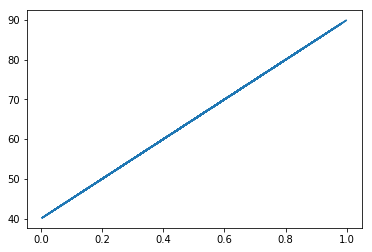

In [43]:
plt.plot(X, Y);

Let’s make things a tiny bit more interesting by adding a bit of noise to our dependent variable.

In [44]:
Y = np.vectorize(lambda y: y + np.random.normal(loc=0.0, scale=0.05))(Y)

## Using TensorFlow for Simple Linear Regression

In [45]:
a_var = tf.Variable(1.0)
b_var = tf.Variable(1.0)
y_var = a_var * X + b_var

Our task will be to minimize the mean squared error or in TensorFlow parlance - reduce the mean.

In [46]:
loss = tf.reduce_mean(tf.square(y_var - Y))

So, let’s try to minimize it using gradient descent.

In [47]:
optimizer = tf.train.GradientDescentOptimizer(0.5)
train = optimizer.minimize(loss)

Let’s use our optimizer for 300 steps of learning

In [48]:
TRAINING_STEPS = 300
results = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for step in range(TRAINING_STEPS):
        results.append(sess.run([train, a_var, b_var])[1:])

Let’s get the final and best predictions for $a$ and $b$

In [49]:
final_pred = results[-1]
a_hat = final_pred[0]
b_hat = final_pred[1]
y_hat = a_hat * X + b_hat

print(f"a_hat: {a_hat} b_hat: {b_hat}")

a_hat: 50.0164794921875 b_hat: 39.9903678894043


Let's see how the predicted model fits the actual data:

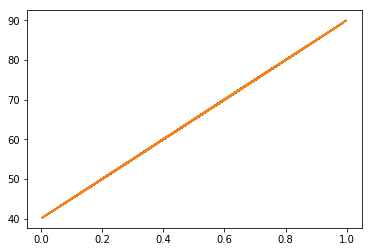

In [50]:
plt.plot(X, Y);
plt.plot(X, y_hat);

That’s a nice fit. Those two lines overlap pretty good, what did you expect? Pretty good for a couple of lines of code.